# Signed Graph Network Analysis

## Setup

In [1]:
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import numpy as np
from scipy.optimize import curve_fit
from scipy.stats import norm

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score,confusion_matrix, mean_absolute_error, root_mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler
import smogn

#regression models
from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor


## Analysis

### A) Graph Import, Adjacency Matrix

In [2]:
# Import the weighted graph using the specified nodes in the first and second columns. The weight is specified in the third column. 
# Generate an adjacency matrix and save it to an Excel file.

In [12]:
graph_df = pd.read_csv("data/soc-sign-bitcoinalpha.csv", header=None)
graph_df.columns = ["source", "target", "weight", "time"]
G = nx.from_pandas_edgelist(graph_df, source="source", target="target", edge_attr="weight", create_using=nx.DiGraph)
graph_df

,source,target,weight,time
0,7188,1,10,1407470400
1,430,1,10,1376539200
2,3134,1,10,1369713600
3,3026,1,10,1350014400
4,3010,1,10,1347854400
...,...,...,...,...
24181,7604,7601,10,1364270400
24182,7601,7604,10,1364270400
24183,7604,7602,10,1364270400
24184,7602,7604,10,1364270400


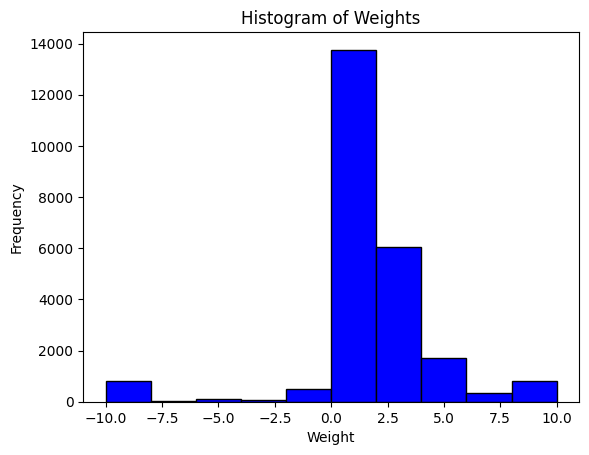

In [13]:
#histogram of weights 
plt.hist(graph_df["weight"], bins=10, color="blue", edgecolor="black")
plt.xlabel("Weight")
plt.ylabel("Frequency")
plt.savefig("plots/histogram_of_weights.pdf")
plt.title("Histogram of Weights")
plt.show()


In [14]:
graph_df["weight"].groupby(graph_df["weight"]).count().sort_values(ascending=False)

weight
 1     13760
 2      4113
 3      1933
 5       957
-10      812
 4       744
 10      494
-1       429
 8       224
 6       201
 7       149
-5       112
 9        75
-2        68
-3        62
-8        15
-4        14
-9        13
-6         6
-7         5
Name: weight, dtype: int64

In [4]:
adjacency_matrix = nx.adjacency_matrix(G).todense()
print("Shape of the adjacency matrix: ", adjacency_matrix.shape)

#save to excel file
adjacency_df = pd.DataFrame(adjacency_matrix)

#adjacency_df.to_excel("data/adjacency_matrix.csv", index=False) -> incredibly slow, therefore chose to save as csv
adjacency_df.to_csv("data/adjacency_matrix.csv", index=False, header=False)

Shape of the adjacency matrix:  (3783, 3783)


### B) Degree Distribtion, Power Law, 

In [5]:
# Using NetworkX, plot the in/out-degree distribution
# and fit the power-law distribution. Use curve fitting and
# confidence bounds of the curve fit library and evaluate
# if the power law distribution can be fit with 80%
# confidence. Additionally, calculate the average clustering
# coefficient and diameter.

In [81]:
def calculate_degrees(degree_dict):
    degree_sequence = sorted([d for n, d in degree_dict], reverse=True)
    degree_count = {}
    for degree in degree_sequence:
        if degree in degree_count:
            degree_count[degree] += 1
        else:
            degree_count[degree] = 1
    return zip(*degree_count.items())


def plot_degree(degree, count, title, save_path):
    plt.bar(degree, count, color='b', label = "NumberOfNodes")
    plt.xlabel("Degree")
    plt.ylabel("Count")
    plt.xlim(0, 100)
    plt.ylim(0, max(count))
    plt.legend()
    plt.savefig(f"plots/{save_path}.pdf")
    #keep title out of saved version
    plt.title(title)
    plt.show()

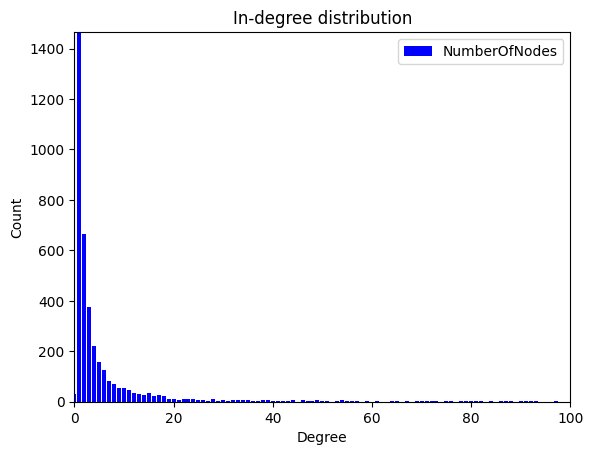

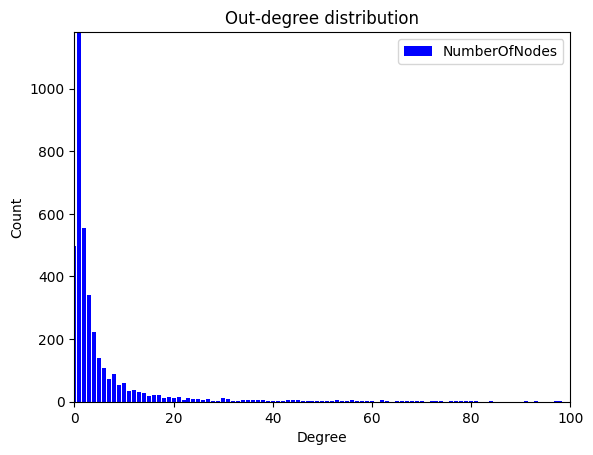

In [82]:
in_degree, in_count = calculate_degrees(G.in_degree())
plot_degree(in_degree, in_count, "In-degree distribution", "B_in_degree_distribution")
out_degree, out_count = calculate_degrees(G.out_degree())
plot_degree(out_degree, out_count, "Out-degree distribution", "B_out_degree_distribution")

In [88]:
# percentage of nodes with in / out degress under 20
in_degree_under_10= sum(in_count[-10:]) / sum(in_count)
out_degree_under_10 = sum(out_count[-10:]) / sum(out_count)

print(f"Percentage of nodes with in-degree under 10: {in_degree_under_10}")
print(f"Percentage of nodes with out-degree under 10: {out_degree_under_10}")

Percentage of nodes with in-degree under 20: 0.8569918054454136
Percentage of nodes with out-degree under 20: 0.8604282315622522


In [84]:
def linlaw(x, a, b) :
    return np.log(a) + x * b

def fit_and_plot_powerlaw(degree, count, title, save_path):
    degree, count = np.log(degree)[:-1], np.log(count)[:-1]
    popt_log, pcov_log = curve_fit(linlaw, degree, count)

    hires_x = np.linspace(0, max(degree), 100)
    # Calculate standard errors of the parameters
    sigma_ab = np.sqrt(np.diagonal(pcov_log))

    # Calculate critical value for an 80% confidence interval
    z = norm.ppf(0.9)  # for an 80% confidence interval

    # Calculate confidence bounds
    bound_upper = linlaw(hires_x, *(popt_log + z * sigma_ab))
    bound_lower = linlaw(hires_x, *(popt_log - z * sigma_ab))

    print(f"Optimal parameters: a={popt_log[0]}, b={popt_log[1]}")
    plt.scatter(degree, count, color='b')
    plt.plot(degree, linlaw(degree, *popt_log), 'r--', label = "Fitted Curve")
    plt.fill_between(hires_x, bound_lower, bound_upper, color='black', alpha=0.15, label='80% Confidence Interval')  # plotting the confidence intervals
    plt.xlabel("log(Degree)")
    plt.ylabel("log(Count)")
    plt.legend(loc='best')
    plt.savefig(f"plots/{save_path}.pdf")
    plt.title(title)
    plt.show()

/tmp/ipykernel_39530/2130378041.py:5: RuntimeWarning: divide by zero encountered in log
  degree, count = np.log(degree)[:-1], np.log(count)[:-1]


Optimal parameters: a=1050.1333867565952, b=-1.4768509049523104


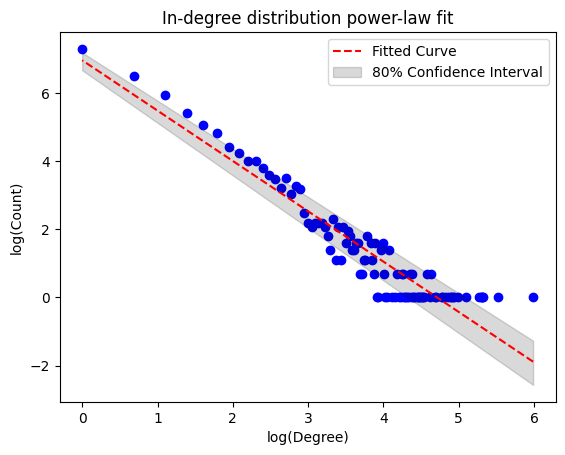

/tmp/ipykernel_39530/2130378041.py:5: RuntimeWarning: divide by zero encountered in log
  degree, count = np.log(degree)[:-1], np.log(count)[:-1]


Optimal parameters: a=745.6386171455763, b=-1.3892366867563806


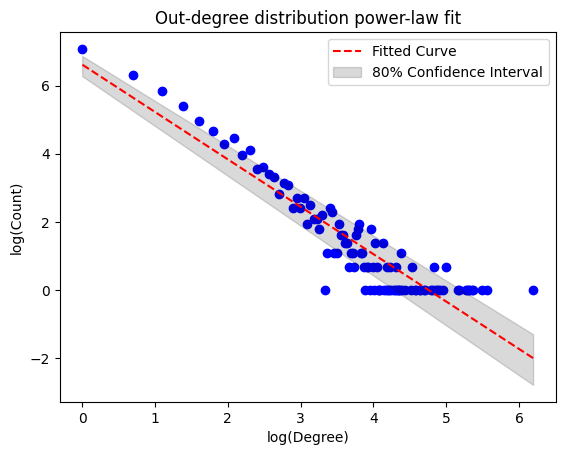

In [85]:
fit_and_plot_powerlaw(in_degree, in_count, "In-degree distribution power-law fit", "B_in_degree_distribution_powerlaw_fit")
fit_and_plot_powerlaw(out_degree, out_count, "Out-degree distribution power-law fit", "B_out_degree_distribution_powerlaw_fit")

In [67]:
#Additionally, calculate the average clustering coefficient and diameter.
average_clustering_coefficient = nx.average_clustering(G)
print("Average clustering coefficient: ", average_clustering_coefficient)

#identify biggest strongly connected component first
strongly_connected_components = nx.strongly_connected_components(G)
biggest_strongly_connected_component = max(strongly_connected_components, key=len)
G_strongly_connected = G.subgraph(biggest_strongly_connected_component)
diameter = nx.diameter(G_strongly_connected)
print("Diameter: ", diameter)


Average clustering coefficient:  0.15834486458303135
Diameter:  10


In [75]:
print(f"dropped nodes: {len(G.nodes) - len(biggest_strongly_connected_component)}")
print(f"dropped edges: {len(G.edges)-len(G_strongly_connected.edges)}")
print(f"nodes: {len(G.nodes)}")
print(f"edges: {len(G.edges)}")

dropped nodes: 548
dropped edges: 887
nodes: 3783
edges: 24186


In [68]:
#do same but treat graph as undirected
connected_components = nx.connected_components(G.to_undirected())
biggest_connected_component = max(connected_components, key=len)
G_connected = G.to_undirected().subgraph(biggest_connected_component)
diameter = nx.diameter(G_connected)
print("Diameter (undirected): ", diameter)

Diameter (undirected):  10


In [80]:
print(f"dropped nodes: {len(G.nodes) - len(biggest_connected_component)}")
print(f"dropped edges: {len(G.to_undirected().edges)-len(G_connected.edges)}")
print(f"nodes: {len(G.nodes)}")
print(f"edges: {len(G.to_undirected().edges)}")

dropped nodes: 8
dropped edges: 4
nodes: 3783
edges: 14124


### F) Link Sign Prediction

#### Create Feature DF

In [127]:
feature_df = graph_df[["source", "target", "weight"]]
#create edge column with tuple of source and target
feature_df["edge"] = list(zip(feature_df["source"], feature_df["target"]))
feature_df

,source,target,weight,edge
0,7188,1,10,"(7188, 1)"
1,430,1,10,"(430, 1)"
2,3134,1,10,"(3134, 1)"
3,3026,1,10,"(3026, 1)"
4,3010,1,10,"(3010, 1)"
...,...,...,...,...
24181,7604,7601,10,"(7604, 7601)"
24182,7601,7604,10,"(7601, 7604)"
24183,7604,7602,10,"(7604, 7602)"
24184,7602,7604,10,"(7602, 7604)"


In [117]:
#calcualte edge betweenness
edge_betweenness = nx.edge_betweenness_centrality(G, seed = 42)

In [125]:
#calcualte edge betweenness with weight
edge_betweenness_weighted = nx.edge_betweenness_centrality(G, weight = "weight", seed = 42)

In [ ]:
#calcualte edge betweenness with weight
edge_betweenness = nx.edge_betweenness_centrality(G, seed = 42)

In [118]:
#calculate degree centrality 
degree_centrality = nx.degree_centrality(G)

In [119]:
#calculate closeness centrality
closeness_centrality = nx.closeness_centrality(G)
closeness_centrality

{7188: 0.0,
 1: 0.3587718223102824,
 430: 0.2441359654296969,
 3134: 0.27113369809780447,
 3026: 0.25328500151903444,
 3010: 0.25328500151903444,
 804: 0.2756907909201678,
 160: 0.2674623921828729,
 95: 0.3372463757150159,
 377: 0.25365148370607593,
 888: 0.25853793960934535,
 89: 0.3101711939424735,
 1901: 0.25328500151903444,
 161: 0.2908116233096721,
 256: 0.3002438564356441,
 351: 0.27978833983259727,
 3329: 0.25328500151903444,
 3341: 0.25328500151903444,
 649: 0.28223768432499374,
 1583: 0.25328500151903444,
 87: 0.3096233697783185,
 37: 0.30948671596841965,
 309: 0.2946919633139092,
 821: 0.2618200417083718,
 1496: 0.25650462796724166,
 637: 0.27631544742604547,
 964: 0.2762610171202391,
 594: 0.2641128160849141,
 2249: 0.25328500151903444,
 554: 0.2678966673182223,
 20: 0.3192440367427484,
 2227: 0.25328500151903444,
 1315: 0.2533994133907117,
 519: 0.2847881111607054,
 1316: 0.25328500151903444,
 2149: 0.2538580963726842,
 1724: 0.2618444834598383,
 18: 0.3120344984783388,
 57

In [128]:
#add edge_betweenness to feature_df
feature_df["edge_betweenness"] = feature_df["edge"].map(edge_betweenness)

#add weighted weighted_edge betweenness
feature_df["edge_betweenness_weighted"] = feature_df["edge"].map(edge_betweenness_weighted)

#add degree centrality to feature_df
feature_df["degree_centrality_source"] = feature_df["source"].map(degree_centrality)
feature_df["degree_centrality_target"] = feature_df["target"].map(degree_centrality)
feature_df["degree_centrality"] = (feature_df["degree_centrality_source"] + feature_df["degree_centrality_target"]) / 2

#add closeness centrality to feature_df
feature_df["closeness_centrality_source"] = feature_df["source"].map(closeness_centrality)
feature_df["closeness_centrality_target"] = feature_df["target"].map(closeness_centrality)
feature_df["closeness_centrality"] = (feature_df["closeness_centrality_source"] + feature_df["closeness_centrality_target"]) / 2

#add sign to feature_df
feature_df["sign"] = np.sign(feature_df['weight'])

#save df
#feature_df.to_csv("data/feature_df.csv", index=False)
feature_df

,source,target,weight,edge,edge_betweenness,edge_betweenness_weighted,degree_centrality_source,degree_centrality_target,degree_centrality,closeness_centrality_source,closeness_centrality_target,closeness_centrality,sign
0,7188,1,10,"(7188, 1)",0.000262,0.000248,0.000264,0.234796,0.117530,0.000000,0.358772,0.179386,1
1,430,1,10,"(430, 1)",0.000416,0.000000,0.003966,0.234796,0.119381,0.244136,0.358772,0.301454,1
2,3134,1,10,"(3134, 1)",0.000111,0.000000,0.001851,0.234796,0.118324,0.271134,0.358772,0.314953,1
3,3026,1,10,"(3026, 1)",0.000262,0.000247,0.000529,0.234796,0.117663,0.253285,0.358772,0.306028,1
4,3010,1,10,"(3010, 1)",0.000262,0.000247,0.000529,0.234796,0.117663,0.253285,0.358772,0.306028,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
24181,7604,7601,10,"(7604, 7601)",0.000019,0.000000,0.024855,0.007139,0.015997,0.318664,0.279984,0.299324,1
24182,7601,7604,10,"(7601, 7604)",0.000007,0.000000,0.007139,0.024855,0.015997,0.279984,0.318664,0.299324,1
24183,7604,7602,10,"(7604, 7602)",0.000017,0.000000,0.024855,0.007932,0.016393,0.318664,0.283694,0.301179,1
24184,7602,7604,10,"(7602, 7604)",0.000005,0.000000,0.007932,0.024855,0.016393,0.283694,0.318664,0.301179,1


#### Load Feature DF

In [15]:
feature_df = pd.read_csv("data/feature_df.csv")
feature_df

,source,target,weight,edge,edge_betweenness,edge_betweenness_weighted,degree_centrality_source,degree_centrality_target,degree_centrality,closeness_centrality_source,closeness_centrality_target,closeness_centrality,sign
0,7188,1,10,"(7188, 1)",0.000262,0.000248,0.000264,0.234796,0.117530,0.000000,0.358772,0.179386,1
1,430,1,10,"(430, 1)",0.000416,0.000000,0.003966,0.234796,0.119381,0.244136,0.358772,0.301454,1
2,3134,1,10,"(3134, 1)",0.000111,0.000000,0.001851,0.234796,0.118324,0.271134,0.358772,0.314953,1
3,3026,1,10,"(3026, 1)",0.000262,0.000247,0.000529,0.234796,0.117663,0.253285,0.358772,0.306028,1
4,3010,1,10,"(3010, 1)",0.000262,0.000247,0.000529,0.234796,0.117663,0.253285,0.358772,0.306028,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
24181,7604,7601,10,"(7604, 7601)",0.000019,0.000000,0.024855,0.007139,0.015997,0.318664,0.279984,0.299324,1
24182,7601,7604,10,"(7601, 7604)",0.000007,0.000000,0.007139,0.024855,0.015997,0.279984,0.318664,0.299324,1
24183,7604,7602,10,"(7604, 7602)",0.000017,0.000000,0.024855,0.007932,0.016393,0.318664,0.283694,0.301179,1
24184,7602,7604,10,"(7602, 7604)",0.000005,0.000000,0.007932,0.024855,0.016393,0.283694,0.318664,0.301179,1


#### Train Models

In [30]:
samplers = [RandomOverSampler(random_state=42), SMOTE(random_state=42), RandomUnderSampler(random_state=42)] #
sampler_names = ["RandomOverSampler","SMOTE","RandomUnderSampler"] #
dfs = []
for sampler_name, sampler in zip(sampler_names, samplers):
    print(f"Using {sampler_name}")
    X = feature_df[["edge_betweenness", "degree_centrality", "closeness_centrality"]].copy().to_numpy()
    y = feature_df["sign"].copy().to_numpy()
    #change -1 to 0
    y[y == -1] = 0

    # ros = RandomOverSampler(random_state=42)
    # X, y = ros.fit_resample(X, y)
    # smote = SMOTE(random_state=42)
    # X, y = smote.fit_resample(X, y)
    # rus = RandomUnderSampler(random_state=42)
    
    X, y = sampler.fit_resample(X, y)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    scaler = MinMaxScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)



    # Initialize models
    models = {
        'Decision Tree': DecisionTreeClassifier(),
        'Random Forest': RandomForestClassifier(),
        'XGBoost': XGBClassifier(),
        'Support Vector Machine': SVC(),
        'Naive Bayes': GaussianNB(),
        'Neural Network': MLPClassifier(),
        'K-Nearest Neighbors': KNeighborsClassifier(),
        'Logistic Regression': LogisticRegression()
        }

    # Training and evaluation loop
    accuracy_scores = []
    f1_scores = []

    for name, model in models.items():
        # Train the model
        model.fit(X_train, y_train)
        
        # Make predictions on the test set
        y_pred = model.predict(X_test)
        
        # Calculate accuracy
        accuracy = accuracy_score(y_test, y_pred)

        #calculate f1 score
        f1 = f1_score(y_test, y_pred)
        
        # Print the accuracy of each model
        # print(f'{name} Accuracy: {accuracy:.4f}')
        # print(f'{name} F1 Score: {f1:.4f}')
        accuracy_scores.append(accuracy)
        f1_scores.append(f1)

        # print confusion matrix
        print(f'{name} Confusion Matrix:')
        print(confusion_matrix(y_test, y_pred))
    
    # Save the accuracy and f1 scores for each sampler
    df = pd.DataFrame({'Model': list(models.keys()), 'Accuracy': accuracy_scores, 'F1 Score': f1_scores})
    dfs.append(df)
    



Using SMOTE


Decision Tree Confusion Matrix:
[[1847 2678]
 [ 647 3878]]
Random Forest Confusion Matrix:
[[1885 2640]
 [ 531 3994]]
XGBoost Confusion Matrix:
[[2372 2153]
 [1042 3483]]
Naive Bayes Confusion Matrix:
[[3731  794]
 [3170 1355]]
K-Nearest Neighbors Confusion Matrix:
[[2273 2252]
 [1103 3422]]
Logistic Regression Confusion Matrix:
[[2617 1908]
 [2415 2110]]


In [32]:
#Random Forest	0.844357	0.913438 for smote just on X train
#Random Forest	0.649613	0.715835 for smote on X train and test

In [34]:
dfs[0]

,Model,Accuracy,F1 Score
0,Decision Tree,0.972958,0.972257
1,Random Forest,0.991170,0.991111
2,XGBoost,0.889845,0.884758
3,Support Vector Machine,0.572296,0.500322
4,Naive Bayes,0.565232,0.433808
5,Neural Network,0.608057,0.631830
6,K-Nearest Neighbors,0.914459,0.906638
7,Logistic Regression,0.548344,0.503398


In [36]:
dfs[1]

,Model,Accuracy,F1 Score
0,Decision Tree,0.863576,0.863032
1,Random Forest,0.886534,0.885676
2,XGBoost,0.798786,0.792487
3,Support Vector Machine,0.576821,0.520990
4,Naive Bayes,0.566004,0.410848
5,Neural Network,0.596358,0.570220
6,K-Nearest Neighbors,0.838852,0.824646
7,Logistic Regression,0.549448,0.500612


In [38]:
dfs[2]

,Model,Accuracy,F1 Score
0,Decision Tree,0.603252,0.596026
1,Random Forest,0.613008,0.605960
2,XGBoost,0.640650,0.631052
3,Support Vector Machine,0.577236,0.460581
4,Naive Bayes,0.552846,0.346793
5,Neural Network,0.582114,0.512334
6,K-Nearest Neighbors,0.611382,0.590051
7,Logistic Regression,0.502439,0.468750


#### Interpret Models

In [20]:
feature_importance = []
for sampler in [RandomOverSampler(random_state=42), SMOTE(random_state=42), RandomUnderSampler(random_state=42)]:

    X = feature_df[["edge_betweenness", "degree_centrality", "closeness_centrality"]].copy().to_numpy()
    y = feature_df["sign"].copy().to_numpy()
    #change -1 to 0
    y[y == -1] = 0
    

    X, y = sampler.fit_resample(X, y)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    scaler = MinMaxScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    model = XGBClassifier()
    model.fit(X_train, y_train)

    feature_importance.append(model.feature_importances_)

feature_importance 

[array([0.32744834, 0.35343608, 0.31911558], dtype=float32),
 array([0.30996463, 0.38932702, 0.3007084 ], dtype=float32),
 array([0.3497686 , 0.33616048, 0.3140709 ], dtype=float32)]

In [26]:
#calculate correlation between X and y

X = feature_df[["edge_betweenness", "degree_centrality", "closeness_centrality"]].to_numpy()
y = feature_df["sign"].copy().to_numpy()

#scale X

scaler = MinMaxScaler()
X = scaler.fit_transform(X)


In [27]:
def correlation(X, y):
    # Concatenate X and y along columns
    data = np.column_stack((X, y))
    
    # Calculate correlation matrix
    corr_matrix = np.corrcoef(data, rowvar=False)
    
    # Extract correlation coefficients between features and y
    corr_with_y = corr_matrix[:-1, -1]
    
    return corr_with_y


# Calculate correlation between X and y
corr = correlation(X, y)
print("Correlation between X and y:", corr)

Correlation between X and y: [ 0.03319572 -0.00960301 -0.03637805]


### G) Link Weight Prediction

#### Generate Balanced Dataset

In [72]:
feature_df = pd.read_csv("data/feature_df.csv")
feature_df_reduced = feature_df[["edge_betweenness", "degree_centrality", "closeness_centrality", "weight"]].copy()

In [26]:
feature_df_smogn = smogn.smoter(
    data = feature_df_reduced,  ## pandas dataframe
    y = 'weight'  ## string ('header name')
)

/home/cernerrood246/anaconda3/envs/SN/lib/python3.9/site-packages/smogn/phi.py:81: RuntimeWarning: divide by zero encountered in scalar divide
  delta.append((y_rel[i + 1] - y_rel[i]) / h[i])
r_index: 100%|##########| 382/382 [00:00<00:00, 560.88it/s]


In [ ]:
feature_df_smogn.to_csv("data/feature_df_smogn.csv", index=False)

In [95]:
# Splitting the DataFrame into features (X) and target variable (y)
X = feature_df_reduced.drop(columns=['weight'])
y = feature_df_reduced['weight']

# Splitting the data into train and test sets (adjust test_size and random_state as needed)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Creating train and test DataFrames
feature_df_smogn_08 = pd.concat([X_train, y_train], axis=1).reset_index(drop=True)
feature_df_smogn_02 = pd.concat([X_test, y_test], axis=1).reset_index(drop=True)

feature_df_smogn_08 = smogn.smoter(
    data = feature_df_smogn_08,  ## pandas dataframe
    y = 'weight'  ## string ('header name')
)

# feature_df_smogn_02 = smogn.smoter(
#     data = feature_df_smogn_02,  ## pandas dataframe
#     y = 'weight'  ## string ('header name')
# )

/home/cernerrood246/anaconda3/envs/SN/lib/python3.9/site-packages/smogn/phi.py:81: RuntimeWarning: divide by zero encountered in scalar divide
  delta.append((y_rel[i + 1] - y_rel[i]) / h[i])
r_index: 100%|##########| 333/333 [00:00<00:00, 660.14it/s]


In [96]:
feature_df_smogn_08.to_csv("data/feature_df_smogn_08.csv", index=False)
feature_df_smogn_02.to_csv("data/feature_df_02.csv", index=False)

#### Load and modify balanced dataset

In [2]:
feature_df_smogn = pd.read_csv("data/feature_df_smogn.csv")
feature_df_smogn_08 = pd.read_csv("data/feature_df_smogn_08.csv")
feature_df_smogn_02 = pd.read_csv("data/feature_df_02.csv")

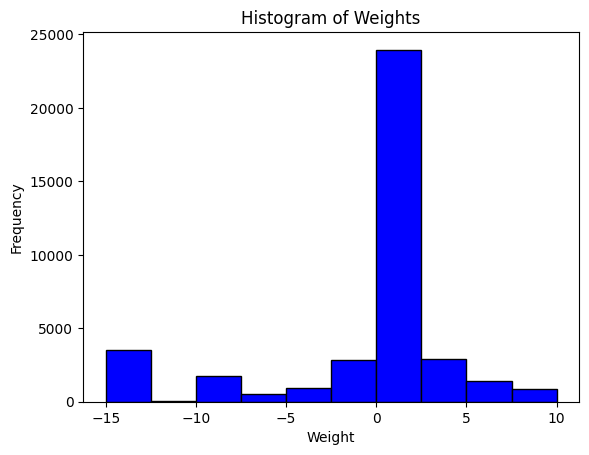

In [3]:
#histogram of weights 
plt.hist(feature_df_smogn["weight"], bins=10, color="blue", edgecolor="black")
plt.xlabel("Weight")
plt.ylabel("Frequency")
plt.savefig("plots/histogram_of_weights_resampled.pdf")
plt.title("Histogram of Weights")
plt.show()

In [4]:
feature_df_smogn = feature_df_smogn.loc[feature_df_smogn["weight"] >= -10]
feature_df_smogn_08 = feature_df_smogn_08.loc[feature_df_smogn_08["weight"] >= -10]
feature_df_smogn_02 = feature_df_smogn_02.loc[feature_df_smogn_02["weight"] >= -10]

feature_df_smogn["weight"] = feature_df_smogn["weight"].astype(int)
feature_df_smogn_08["weight"] = feature_df_smogn_08["weight"].astype(int)
feature_df_smogn_02["weight"] = feature_df_smogn_02["weight"].astype(int)

#### Classification attempt

In [21]:
samplers = [RandomOverSampler(random_state=42), SMOTE(random_state=42), RandomUnderSampler(random_state=42)] #
sampler_names = ["RandomOverSampler","SMOTE","RandomUnderSampler"] #
dfs = []
for sampler_name, sampler in zip(sampler_names, samplers):
    print(f"Using {sampler_name}")
    X = feature_df[["edge_betweenness", "degree_centrality", "closeness_centrality"]].copy().to_numpy()
    y = feature_df["weight"].copy().to_numpy()

    # y = y + 10 #shift to 0-20
    # y[y > 10] = y[y > 10] - 1

    X = X[y > 0].copy()
    y = y[y > 0].copy()

    y = y - 1 
    
    # X, y = sampler.fit_resample(X, y)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    scaler = MinMaxScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)



    # Initialize models
    models = {
        'Decision Tree': DecisionTreeClassifier(),
        'Random Forest': RandomForestClassifier(),
        'XGBoost': XGBClassifier(),
        # 'Support Vector Machine': SVC(),
        'Naive Bayes': GaussianNB(),
        # 'Neural Network': MLPClassifier(),
        'K-Nearest Neighbors': KNeighborsClassifier(),
        'Logistic Regression': LogisticRegression()
        }

    # Training and evaluation loop
    accuracy_scores = []
    f1_scores = []

    for name, model in models.items():
        # Train the model
        model.fit(X_train, y_train)
        
        # Make predictions on the test set
        y_pred = model.predict(X_test)
        
        # Calculate accuracy
        accuracy = accuracy_score(y_test, y_pred)

        #calculate f1 score
        f1 = f1_score(y_test, y_pred, average = "micro")
        
        # Print the accuracy of each model
        # print(f'{name} Accuracy: {accuracy:.4f}')
        # print(f'{name} F1 Score: {f1:.4f}')
        accuracy_scores.append(accuracy)
        f1_scores.append(f1)

        # print confusion matrix
        # print(f'{name} Confusion Matrix:')
        # print(confusion_matrix(y_test, y_pred))
    
    # Save the accuracy and f1 scores for each sampler
    df = pd.DataFrame({'Model': list(models.keys()), 'Accuracy': accuracy_scores, 'F1 Score': f1_scores})
    dfs.append(df)
    break

Using RandomOverSampler


/home/cernerrood246/anaconda3/envs/SN/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [22]:
dfs

[                 Model  Accuracy  F1 Score
 0        Decision Tree  0.499338  0.499338
 1        Random Forest  0.596909  0.596909
 2              XGBoost  0.597351  0.597351
 3          Naive Bayes  0.588300  0.588300
 4  K-Nearest Neighbors  0.571744  0.571744
 5  Logistic Regression  0.601545  0.601545]

#### Classification Attempt with SMOGN

In [58]:
X = feature_df_smogn[["edge_betweenness", "degree_centrality", "closeness_centrality"]].copy().to_numpy()
y = feature_df_smogn["weight"].copy().to_numpy()


y = y + 10 #shift to 0-20
y[y > 10] = y[y > 10] - 1

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Initialize models
models = {
    # 'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    # 'XGBoost': XGBClassifier(),
    # 'Support Vector Machine': SVC(),
    # 'Naive Bayes': GaussianNB(),
    # 'Neural Network': MLPClassifier(),
    # 'K-Nearest Neighbors': KNeighborsClassifier(),
    # 'Logistic Regression': LogisticRegression()
    }

# Training and evaluation loop
accuracy_scores = []
f1_scores = []

for name, model in models.items():
    # Train the model
    model.fit(X_train, y_train)
    
    # Make predictions on the test set
    y_pred = model.predict(X_test)
    
    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)

    #calculate f1 score
    f1 = f1_score(y_test, y_pred, average = "micro")
    
    # Print the accuracy of each model
    # print(f'{name} Accuracy: {accuracy:.4f}')
    # print(f'{name} F1 Score: {f1:.4f}')
    accuracy_scores.append(accuracy)
    f1_scores.append(f1)

    # print confusion matrix
    print(f'{name} Confusion Matrix:')
    #revert back to original weights
    y_test[y_test >= 10] = y_test[y_test >= 10] + 1
    y_pred[y_pred >= 10] = y_pred[y_pred >= 10] + 1

    y_test = y_test - 10
    y_pred = y_pred - 10
    
    conf_matrix = confusion_matrix(y_test, y_pred)
    print(conf_matrix)

# Save the accuracy and f1 scores for each sampler
df = pd.DataFrame({'Model': list(models.keys()), 'Accuracy': accuracy_scores, 'F1 Score': f1_scores})
df

Random Forest Confusion Matrix:
[[ 243    0    0    2    0    0    0    0    0    6   61    2    4    0
     0    0    1    0    0    0]
 [   1    5    0    0    0    0    0    0    0    0    5    1    0    0
     0    0    0    0    0    0]
 [   0    0    3    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0]
 [   0    0    0   23    0   10    0    1    0    2   55    2    3    0
     0    0    0    1    0    0]
 [   0    0    0    0    2    0    0    0    0    0    3    1    1    0
     0    0    0    0    0    0]
 [   0    0    0    2    0   37    0    0    0    0    8    0    0    0
     0    0    0    0    0    0]
 [   0    0    0    0    0    0   19    7    0    1   32    1    3    0
     1    0    0    0    0    0]
 [   0    0    0    0    0    0    1   37    6    1   27    4    0    0
     0    0    0    0    0    1]
 [   0    0    0    0    0    0    0    2   29    0    0    0    0    0
     0    0    0    0    0    0]
 [   4    0    2    1  

,Model,Accuracy,F1 Score
0,Random Forest,0.697245,0.697245


In [68]:
index = np.arange(-10, 11)
index = np.delete(index, 10)
conf_matrix_df = pd.DataFrame(conf_matrix, index=index, columns=index)
#calculate mean correct per class as row
conf_matrix_df.loc["mean_correct"] = conf_matrix_df.apply(lambda x: x[x.name] / sum(x), axis=0)
conf_matrix_df.style.background_gradient(cmap='Blues')


,-10,-9,-8,-7,-6,-5,-4,-3,-2,-1,1,2,3,4,5,6,7,8,9,10
-10,243.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,61.000000,2.000000,4.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
-9,1.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
-8,0.000000,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
-7,0.000000,0.000000,0.000000,23.000000,0.000000,10.000000,0.000000,1.000000,0.000000,2.000000,55.000000,2.000000,3.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
-6,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
-5,0.000000,0.000000,0.000000,2.000000,0.000000,37.000000,0.000000,0.000000,0.000000,0.000000,8.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
-4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,19.000000,7.000000,0.000000,1.000000,32.000000,1.000000,3.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
-3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,37.000000,6.000000,1.000000,27.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
-2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,29.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
-1,4.000000,0.000000,2.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,356.000000,164.000000,16.000000,1.000000,0.000000,1.000000,0.000000,0.000000,2.000000,0.000000,0.000000


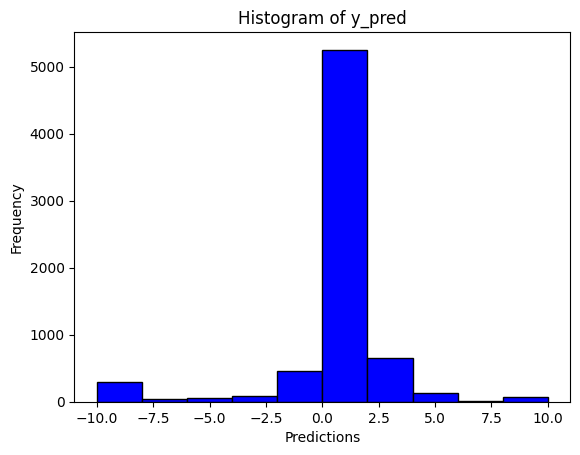

In [71]:
plt.hist(y_pred, bins=10, color="blue", edgecolor="black")
plt.xlabel('Predictions')
plt.ylabel('Frequency')
plt.savefig("plots/histogram_of_weights_predicted_classifier.pdf")
plt.title('Histogram of y_pred')
plt.show()


#### Classification Attempt with split SMOGN

In [112]:
X_train, X_test = feature_df_smogn_08[["edge_betweenness", "degree_centrality", "closeness_centrality"]].copy().to_numpy(), feature_df_smogn_02[["edge_betweenness", "degree_centrality", "closeness_centrality"]].copy().to_numpy()
y_train, y_test = feature_df_smogn_08["weight"].copy().to_numpy(), feature_df_smogn_02["weight"].copy().to_numpy()

y_train = y_train + 10 #shift to 0-20
y_train[y_train > 10] = y_train[y_train > 10] - 1

y_test = y_test + 10 #shift to 0-20
y_test[y_test > 10] = y_test[y_test > 10] - 1

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Initialize models
models = {
    # 'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    # 'XGBoost': XGBClassifier(),
    # 'Support Vector Machine': SVC(),
    # 'Naive Bayes': GaussianNB(),
    # 'Neural Network': MLPClassifier(),
    # 'K-Nearest Neighbors': KNeighborsClassifier(),
    # 'Logistic Regression': LogisticRegression()
    }

# Training and evaluation loop
accuracy_scores = []
f1_scores = []
mae_scores = []
rmse_scores = []

for name, model in models.items():
    # Train the model
    model.fit(X_train, y_train)
    
    # Make predictions on the test set
    y_pred = model.predict(X_test)
    
    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)

    #calculate f1 score
    f1 = f1_score(y_test, y_pred, average = "micro")

    #calculate MAE using scitkit learn
    mae = mean_absolute_error(y_test / 10, y_pred / 10)

    rmse = root_mean_squared_error(y_test / 10, y_pred / 10)
    
    # Print the accuracy of each model
    # print(f'{name} Accuracy: {accuracy:.4f}')
    # print(f'{name} F1 Score: {f1:.4f}')
    accuracy_scores.append(accuracy)
    f1_scores.append(f1)
    mae_scores.append(mae)
    rmse_scores.append(rmse)

    print(f"mae:{mae}")

    # print confusion matrix
    # print(f'{name} Confusion Matrix:')
    #revert back to original weights
    # y_test[y_test >= 10] = y_test[y_test >= 10] + 1
    # y_pred[y_pred >= 10] = y_pred[y_pred >= 10] + 1

    # y_test = y_test - 10
    # y_pred = y_pred - 10
    
    # conf_matrix = confusion_matrix(y_test, y_pred)
    # print(conf_matrix)

# Save the accuracy and f1 scores for each sampler
df = pd.DataFrame({'Model': list(models.keys()), 'Accuracy': accuracy_scores, 'F1 Score': f1_scores, 'MAE Scores':mae_scores, 'RMSE':rmse_scores})
df

mae:0.13945845390657297


,Model,Accuracy,F1 Score,MAE Scores,RMSE
0,Random Forest,0.561389,0.561389,0.139458,0.296336


In [101]:
index = np.arange(-10, 11)
index = np.delete(index, 10)
conf_matrix_df = pd.DataFrame(conf_matrix, index=index, columns=index)
#calculate mean correct per class as row
conf_matrix_df.loc["mean_correct"] = conf_matrix_df.apply(lambda x: x[x.name] / sum(x), axis=0)
conf_matrix_df.style.background_gradient(cmap='Blues')


/tmp/ipykernel_250605/780401896.py:5: RuntimeWarning: invalid value encountered in scalar divide
  conf_matrix_df.loc["mean_correct"] = conf_matrix_df.apply(lambda x: x[x.name] / sum(x), axis=0)


,-10,-9,-8,-7,-6,-5,-4,-3,-2,-1,1,2,3,4,5,6,7,8,9,10
-10,16.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,9.000000,114.000000,15.000000,3.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
-9,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
-8,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
-7,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
-6,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
-5,4.000000,0.000000,0.000000,0.000000,0.000000,3.000000,1.000000,0.000000,0.000000,1.000000,15.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
-4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
-3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,8.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
-2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,10.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
-1,1.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,21.000000,60.000000,5.000000,2.000000,0.000000,2.000000,0.000000,1.000000,0.000000,0.000000,0.000000


In [102]:
conf_matrix_df.to_numpy()

array([[1.60000000e+01, 0.00000000e+00, 0.00000000e+00, 1.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 1.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 9.00000000e+00, 1.14000000e+02, 1.50000000e+01,
        3.00000000e+00, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 1.00000000e+00, 1.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 1.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.0000

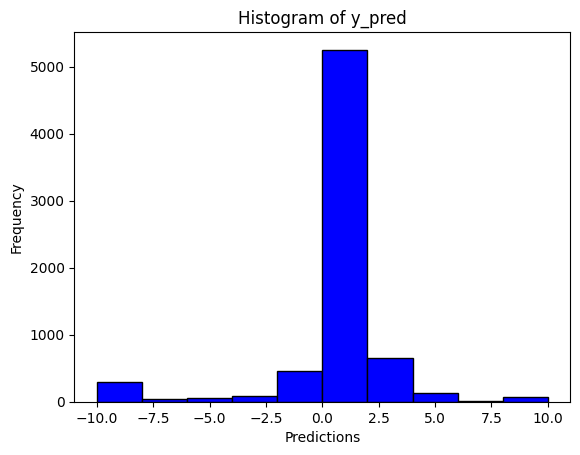

In [ ]:
plt.hist(y_pred, bins=10, color="blue", edgecolor="black")
plt.xlabel('Predictions')
plt.ylabel('Frequency')
plt.savefig("plots/histogram_of_weights_predicted_classifier.pdf")
plt.title('Histogram of y_pred')
plt.show()


#### Regression

In [24]:
X_train, X_test = feature_df_smogn_08[["edge_betweenness", "degree_centrality", "closeness_centrality"]].copy().to_numpy(), feature_df_smogn_02[["edge_betweenness", "degree_centrality", "closeness_centrality"]].copy().to_numpy()
y_train, y_test = feature_df_smogn_08["weight"].copy().to_numpy(), feature_df_smogn_02["weight"].copy().to_numpy()

y_train = y_train + 10  # shift to 0-20
y_train[y_train > 10] = y_train[y_train > 10] - 1

y_test = y_test + 10  # shift to 0-20
y_test[y_test > 10] = y_test[y_test > 10] - 1

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Initialize models
models = {
    # 'Linear Regression': LinearRegression(),
    # 'Elastic Net': ElasticNet(),
    # 'GBDT': GradientBoostingRegressor(),
    # 'Support Vector Regression': SVR(),
    'Random Forest Regression': RandomForestRegressor(),
    # 'K-Nearest Neighbors Regressor': KNeighborsRegressor(),
    # 'XGBoost Regression': XGBRegressor()
}

mae_scores = []
rmse_scores = []

for name, model in models.items():
    # Train the model
    model.fit(X_train, y_train)
    
    # Make predictions on the test set
    y_pred = model.predict(X_test)

    # Calculate MAE and RMSE
    mae = mean_absolute_error(y_test / 10, y_pred / 10)
    rmse = root_mean_squared_error(y_test / 10, y_pred / 10)
    
    mae_scores.append(mae)
    rmse_scores.append(rmse)

    print(f"{name} - MAE: {mae}, RMSE: {rmse}")
    print(f"Mean Prediction: {y_pred.mean()}")

# Save the MAE and RMSE scores for each model
df = pd.DataFrame({'Model': list(models.keys()), 'MAE': mae_scores, 'RMSE': rmse_scores})
df

Random Forest Regression - MAE: 0.1585836209954224, RMSE: 0.2735313327451628
Mean Prediction: 10.255369980507348


,Model,MAE,RMSE
0,Random Forest Regression,0.158584,0.273531


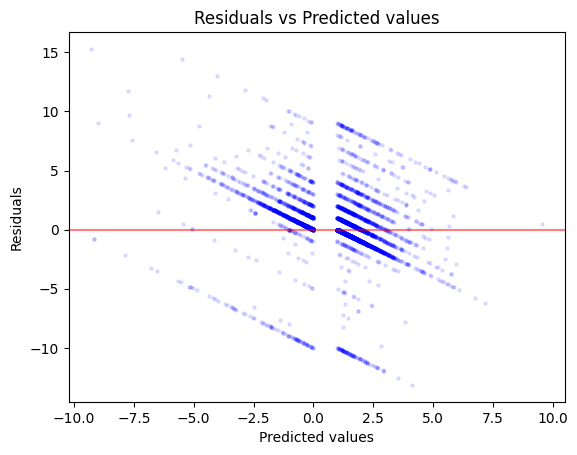

In [25]:
residuals = y_test - y_pred
y_pred[y_pred >= 10] = y_pred[y_pred >= 10] + 1
y_pred = y_pred - 10


plt.axhline(y=0, color='r', linestyle='-', alpha = 0.5)
plt.scatter(y_pred, residuals, color='blue', s = 5, alpha = 0.1)
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
# plt.savefig("plots/G_regresions_residuals.pdf")
plt.title('Residuals vs Predicted values')
plt.show()

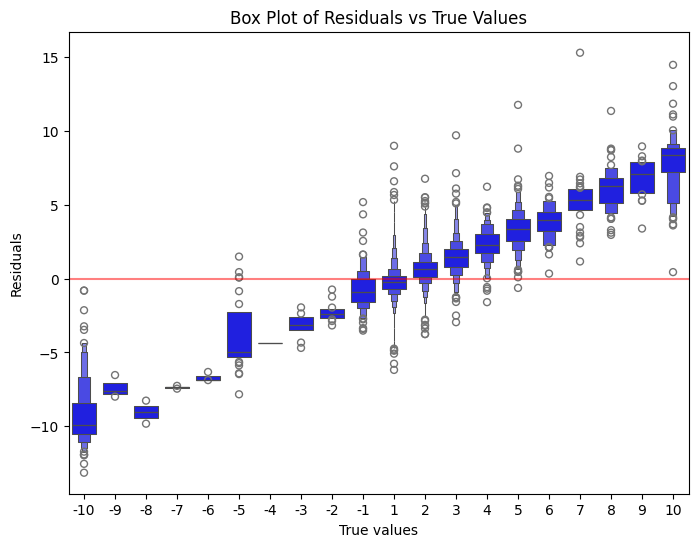

In [30]:
import seaborn as sns
import matplotlib.pyplot as plt

y_test[y_test >= 10] = y_test[y_test >= 10] + 1
y_test = y_test - 10


# Create violin plot
plt.figure(figsize=(8, 6))
sns.boxenplot(x=y_test, y=residuals, color='blue', alpha=1)
plt.axhline(y=0, color='red', linestyle='-', alpha=0.5)
plt.xlabel('True values')
plt.ylabel('Residuals')
plt.savefig("plots/G_regresions_residuals_box.pdf", bbox_inches='tight')
plt.title('Box Plot of Residuals vs True Values')
plt.show()